In [1]:
# https://www.tensorflow.org/text/tutorials/transformer

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2022-09-29 12:34:46.363343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 12:34:46.533035: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 12:34:47.740653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-29 12:34:47.740728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

# Data handling

## Download the dataset

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

2022-09-29 12:56:30.205994: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteTT9Z48/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteTT9Z48/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteTT9Z48/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


2022-09-29 12:57:36.870676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:57:37.461223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:57:37.462632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:57:37.465876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2022-09-29 13:00:11.771914: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Set up the tokenizer

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 1us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [10]:
en_examples.numpy()

array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
       b'but what if it were active ?',
       b"but they did n't test for curiosity ."], dtype=object)

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [17]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

encoded[0].shape

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


TensorShape([27])

In [29]:
encoded.row_lengths()

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([27,  9, 12])>

In [26]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

len(round_trip[0].numpy().decode("utf-8").split(' '))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


20

In [13]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [30]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

In [31]:
lengths

[<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([45, 21, 23, ..., 21, 47, 35])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([27,  9, 12, ...,  9, 23, 28])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 32,  22,  34, ...,  39, 101,  36])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([17, 12, 20, ..., 30, 56, 13])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([48, 37, 27, ..., 92, 21, 49])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([29, 18, 15, ..., 53, 13, 29])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([72, 38, 35, ..., 20, 54, 13])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([38, 18, 16, ..., 11, 26, 11])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 15,  24,  51, ...,  27,  40, 117])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([10, 16, 24, ..., 20, 24, 71])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([28, 44, 26, ..., 95, 34, 32])>,
 <tf.Tensor: shape=(1024,), dtype=int64, n

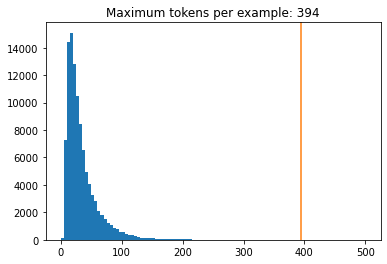

In [43]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

# Set up a data pipeline with tf.data

In [44]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels